In [29]:
import pandas as pd
import numpy as np
import math
import operator
import matplotlib.pyplot as plt
%matplotlib inline  

In [16]:
nba = pd.read_csv('NBA_Player_Stats_16-17.csv', encoding = "ISO-8859-1")
nba = pd.DataFrame(nba)

# Normalize quantitative variables
cols_to_norm = nba.columns[5:]
nba[cols_to_norm] = nba[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

#random_state=nba.shape[0]
train = nba.sample(frac=0.7)
train = pd.DataFrame(train)

test = nba.drop(train.index)
test = pd.DataFrame(test)

list_of_players = np.array(nba.iloc[0:]["Player"])
list_of_players_test = np.array(test.iloc[0:]["Player"])
list_of_players_train = np.array(train.iloc[0:]["Player"])  

In [17]:
# Function returns tuple (actual distance from player 1, player 2 name)
def EuclidianDistance(Player_1, Player_2, data_set):
    player1 = data_set.loc[data_set['Player'] == Player_1]
    #player1.drop(player.columns[[0, 1, 2, 3]], axis=1, inplace= True)
                
    player2 = data_set.loc[data_set['Player'] == Player_2]
    #player2.drop(player.columns[[0, 1, 2, 3]], axis=1, inplace= True)

    distance = math.sqrt(sum(player1.iloc[0][5:25] - player2.iloc[0][5:25])**2)
    return distance, player2.iloc[0][0]

In [18]:
# itertate through all players and compare to Russell Westbrook. Store tuple of distances, player names 
def ClosestPlayersTo(Player_Name):
    distances = ()
    for i in range(len(list_of_players)):
        distances = distances + EuclidianDistance(Player_Name, list_of_players[i], nba)

    # convert stored tuples of distances and players into seperate numpy arrays and 
    # combine into pandas data frame and sort by dist.
    dist = []
    for i in range(0,len(distances), 2):
        dist.append(distances[i])
    dist = np.array(dist)
    players = []
    for i in range(1, len(distances), 2):
        players.append(distances[i])
    players = np.array(players)
    data = pd.DataFrame({'Distances':dist, 'Players':players})
    data = data.sort_values('Distances')
    return data.iloc[1:10]

In [19]:
###### Question 1
ClosestPlayersTo("Russell Westbrook")
#nba.loc[nba['Player'] == "LeBron James"]
#nba.loc[nba['Player'] == "John Wall"]

,Distances,Players
175,0.604736,James Harden
270,1.887375,LeBron James
209,2.315093,John Wall
27,2.481884,Anthony Davis
145,2.600688,Giannis Antetokounmp
100,2.621476,DeMarcus Cousins
398,2.755040,Stephen Curry
236,3.015687,Karl-Anthony Towns
198,3.052168,Jimmy Butler


In [20]:
###### Question 2, KNN Algorithm

In [21]:
# Function returns actual distance from player 1, player 2
def EuclidianDistance_KNN(Player_1, Player_2):
    player1 = train.loc[train['Player'] == Player_1]
    #player1.drop(player.columns[[0, 1, 2, 3]], axis=1, inplace= True)
                
    player2 = test.loc[test['Player'] == Player_2]
    #player2.drop(player.columns[[0, 1, 2, 3]], axis=1, inplace= True)

    distance = math.sqrt(sum(player1.iloc[0][5:25] - player2.iloc[0][5:25])**2)
    return distance

In [22]:
# gets neighbors for only 1 observation in test set
import operator
def getNeighbors(train_set, Test_Player, k):
    distances = []
    for x in range(len(train_set)):
        dist = EuclidianDistance_KNN(str(train_set.iloc[x][0]), Test_Player)
        distances.append((train_set.iloc[x][0], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

In [23]:
# Get ALL Top K Neighbors for each observation in test set
def getALLNeighbors(train_set, k):
    neighbors_array = []
    #list_of_players_test = np.array(test.iloc[0:]["Player"])
    #list_of_players_train = np.array(train.iloc[0:]["Player"])
    #for i in range (5):  # Look at first 5 test observations only for now
    for i in range(len(test)):
        neighbors_array.append(getNeighbors(train, list_of_players_test[i], k))
    return neighbors_array

In [24]:
# Resize 1d list into mutlidimensional list
def to_matrix(l, n):
    return [l[i:i+n] for i in range(0, len(l), n)]

In [25]:
def GetLabels(neighbors_array, k):
    labels_train = []
    for i in range(len(neighbors_array)):
        for j in range(len(neighbors_array[i])):
            player = train.loc[train['Player'] == neighbors_array[i][j]]
            labels_train.append(player.iloc[0][4])

    labels_train = to_matrix(labels_train, k)
    labels_train = np.array(labels_train)


    labels_test = []
    #for i in list_of_players_test[0:5]: # Look at first 4 test observations only for now
    for i in list_of_players_test:
        player = test.loc[test['Player'] == i] 
        label = player.iloc[0][4]
        labels_test.append(label)
    labels_test = np.array(labels_test)
    return labels_train, labels_test

In [26]:
def getResponse(neighbors_arrar):
    answer = []
    for x in range(len(neighbors_array)):
        classVotes = {}
        for i in range(len(neighbors_array[x])):
            player = train.loc[train['Player'] == neighbors_array[x][i]]
            response = player.iloc[0][4]
            if response in classVotes:
                classVotes[response] += 1
            else: 
                classVotes[response] = 1
        np.array(answer.append(classVotes))
    sortedValues = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return answer

In [27]:
def Accuracy(predictions, actual):
    N = len(predictions)
    count = 0
    for i in range(len(predictions)):
        if actual[i] == predictions[i]:
            count = count + 1
    return count / N

In [ ]:
# Iterate through k-values and see how accuracy changes for k = 1 to 20 for 5 different train, test sets
# https://www.nbastuffer.com/2016-2017-nba-regular-season-player-stats/
# https://www.nbastuffer.com/2017-2018-nba-player-stats/
cross_validation = []
for j in range(5):
    nba = pd.read_csv('NBA_Player_Stats_16-17.csv', encoding = "ISO-8859-1")
    nba = pd.DataFrame(nba)

    # Normalize quantitative variables
    cols_to_norm = nba.columns[5:]
    nba[cols_to_norm] = nba[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    #random_state=nba.shape[0]
    train = nba.sample(frac=0.7)
    train = pd.DataFrame(train)

    test = nba.drop(train.index)
    test = pd.DataFrame(test)

    list_of_players = np.array(nba.iloc[0:]["Player"])
    list_of_players_test = np.array(test.iloc[0:]["Player"])
    list_of_players_train = np.array(train.iloc[0:]["Player"])
    
    accuracies = []
    for i in range(1,21):
        print(i)
        neighbors_array = getALLNeighbors(train, i)
        knn_labels, true_labels = GetLabels(neighbors_array, i)
        #print(knn_labels)
        #print(true_labels)
        answer = getResponse(neighbors_array)
        predict = []
        for j in answer:
            np.array(predict.append(max(j.items(), key=operator.itemgetter(1))[0]))
        accuracy = Accuracy(predict, true_labels)
        accuracies.append(accuracy)
    #print(accuracies)
    cross_validation.append(accuracies)
print(cross_validation)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


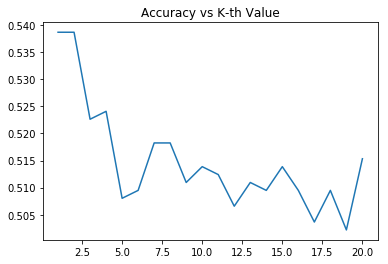

In [34]:
k = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
cross_validation = np.array(cross_validation)
mean_k = np.mean(cross_validation, axis = 0)
plt.plot(k, mean_k)
plt.title("Accuracy vs K-th Value")

In [32]:
cross_validation

array([[ 0.53284672,  0.53284672,  0.60583942,  0.5620438 ,  0.54014599,
         0.55474453,  0.54014599,  0.53284672,  0.53284672,  0.52554745,
         0.50364964,  0.51824818,  0.50364964,  0.48905109,  0.53284672,
         0.51094891,  0.51094891,  0.51824818,  0.48175182,  0.51094891],
       [ 0.47445255,  0.47445255,  0.40145985,  0.4379562 ,  0.49635036,
         0.4379562 ,  0.48905109,  0.48905109,  0.44525547,  0.45255474,
         0.51094891,  0.43065693,  0.48905109,  0.44525547,  0.46715328,
         0.45985401,  0.47445255,  0.48905109,  0.49635036,  0.48905109],
       [ 0.55474453,  0.55474453,  0.49635036,  0.51824818,  0.46715328,
         0.51094891,  0.51824818,  0.48175182,  0.50364964,  0.50364964,
         0.51094891,  0.52554745,  0.48905109,  0.51824818,  0.49635036,
         0.50364964,  0.46715328,  0.48175182,  0.46715328,  0.50364964],
       [ 0.56934307,  0.56934307,  0.55474453,  0.54014599,  0.51824818,
         0.51094891,  0.51094891,  0.53284672,  

In [33]:
mean_k

array([ 0.53868613,  0.53868613,  0.52262774,  0.52408759,  0.5080292 ,
        0.50948905,  0.51824818,  0.51824818,  0.51094891,  0.51386861,
        0.51240876,  0.50656934,  0.51094891,  0.50948905,  0.51386861,
        0.50948905,  0.50364964,  0.50948905,  0.50218978,  0.51532847])